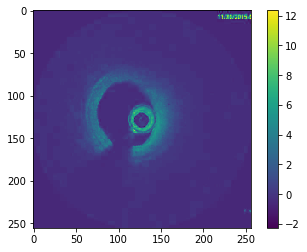

In [2]:
import os, sys, time, tqdm, numbers, math, shutil

os.chdir('/workspace/oct_ca_seg/')

from pathlib import Path
import torch as t
import numpy as np
import pandas as pd
from fastai.vision import get_files
import PIL.Image as pil
from matplotlib.pyplot import imshow
import matplotlib.cm as cm
import seg_model.src.model as m
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

data_in_path = Path('/workspace/oct_ca_seg/dummy_data_for_script/')
data_out_path = Path('/workspace/oct_ca_seg/dummy_data_for_script/dummy_out')

if not os.path.exists(data_out_path):
    os.mkdir(data_out_path)
elif len(os.listdir(data_out_path)) != 0:
    shutil.rmtree(data_out_path)
    os.mkdir(data_out_path)

#data set stuff

from seg_model.nbs.useful.dataset import *

def normalize(octimage):
    means = octimage.view(3,-1).mean(-1)
    stds = octimage.view(3,-1).std(-1)
    return (octimage - means[:,None,None])/stds[:,None,None]

#dataset class
class OCTScriptDataset(Dataset):
    """
    First we create a dataset that will encapsulate our data. It has 3 special 
    functions which will be explained as they go. We will pass this dataset object
    to the torch dataloader object later which will make training easier.
    """
    def __init__ (self,
                  main_data_dir,
                  start_size,
                  cropped_size,
                  transform,
                  input_images,
                  cuda):
        self.main_data_dir = main_data_dir
        self.start_size = start_size
        self.transform = transform
        self.cropped_size = cropped_size
        self.input_images = input_images
        self.cuda = cuda
        self.name_list = get_files(main_data_dir)
        
    def visualise(self, idx):
        
        sample = self.__getitem__(idx)
        input_data = sample['input'].cpu().numpy()[0,:,:]
        #l_data = sample['label'].cpu().numpy()[0,:,:]

        
        """
        f, (axin, axl, ax1comb) = plt.subplots(1,3, sharey=True)
        f.subplots_adjust(hspace=0.3)
        plt.tight_layout()
        """
        #plot image
        
        f, ax =  plt.subplots(1,1)
        image = ax.imshow(input_data,
                            aspect = 'equal')
        
        f.colorbar(image, ax=ax, orientation='vertical', fraction = 0.05)
        """
        axl.imshow(l_data,
                   aspect = 'equal')
        
        combined = input_data + 10 * l_data 
        """
        
        #ax1comb.imshow(combined, aspect = 'equal')
        #plt.show()
        
    def __getitem__(self, idx):
        """This function will allow us to index the data object and it will 
        return a sample."""
        name = self.name_list[idx]
        
        #load data  
        #label = np.array(pil.open(name.parent.parent/str('labels/' + name.name)))
        #print(Path('/workspace/oct_ca_seg/data_oct/labels/')/str(name))
        #print(label.shape)
        
        image = np.array(pil.open(name))
        
        image = image.astype(float)
        #label = label.astype(float)
        #print(image.shape)
        
        #print(label.max())
        #print(Image.shape)
        if self.transform:
            
            ysize = self.start_size[0] + 20
            xsize = self.start_size[1] + 20
            image = skitransforms.resize(image, output_shape=(ysize, xsize))
            label = skitransforms.resize(label, output_shape=(ysize, xsize))
            
            
            #print(label.shape)
            #print(label.max())
            image, label = self.rcrop(image, label)
            #print(label.max())
            
            if self.phflip>0.5:
                #hflip
                image = np.flip(image, 1)
                label = np.flip(label, 1)    
                #print(label.max())
            #print(label.shape)
            
            if self.pvflip>0.5:
                #vflip
                image = np.flip(image, 0)
                label = np.flip(label, 0)
                #print(label.max())
            #print(label.shape)
            
            angle = np.random.randint(0,360)
            image = skitransforms.rotate(image, angle=angle, mode='reflect')
            label = skitransforms.rotate(label, angle=angle, mode='reflect')
            #print(label.max())
            #print(label.shape)
            
            if np.random.rand() > 0.9:
                image = self.spnoise(image)
            
            if np.random.rand() > 0.5:
                image = gaussian(image, sigma=1, mode='reflect')
            
            
        else:
            image = skitransforms.resize(image, output_shape=self.start_size)
            #label = skitransforms.resize(label, output_shape= self.start_size)
        
        #image = np.expand_dims(preprocessing.scale(image[:,:,0]), -1)
        
        #label = np.transpose(label.copy(), (2, 0, 1))
        image = np.transpose(image.copy(), (2, 0, 1))
        #og = preprocessing.MinMaxScaler(og)
        
        #label = torch.tensor(label).float()
        
        #label = torch.gt(label.sum(dim=0).unsqueeze(0), 200).float()
        
        image = torch.tensor(image).float()
        #print(image.size(), label.shape)
        image = normalize(image)
        
        
        sample = {'input': image[self.input_images],
                  'case_name': [str(name.name)]}

        return sample
    
    def __len__(self):    
        """This function is mandated by Pytorch and allows us to see how many 
        data points we have in our dataset"""
        return len(self.name_list)
    


data = OCTScriptDataset(data_in_path,(256,256),(256,256),transform=False,input_images=[0,1,2], cuda=False)
data_loader = DataLoader(data, batch_size=1, shuffle=False)

data.visualise(8), len(data)

opts = {'activation': 'relu',
'batch_size': 2,
'c_size': (256, 256),
'cuda' : True,
'dataroot': '/workspace/oct_ca_seg/data_oct',
'start_size': (256, 256),
'device': 'cuda',
'input_images': [0,1,2],
'transforms':False,      
'dims1': 24,
'dims2': 32,
'dims3': 48,
'epochs': 40,
'f1dims': 32,
'f1maps': 2,
'f2dims': 16,
'f2maps': 1,
'inputchannels': 3,
'normalization': 'batch',
'primdims': 16,
'primmaps': 4,
'reconchannels': 1,
'maps1': 8,
'maps2': 16,
'maps3': 24,
'uptype': 'deconv',
}

optsagain = {'activation': 'relu',
'batch_size': 2,
'c_size': (256, 256),
'comet': False,
'dataroot': '/workspace/oct_ca_seg/data_oct',
'device': 'cuda',
'dims1': 24,
'dims2': 32,
'dims3': 48,
'epochs': 40,
'f1dims': 32,
'f1maps': 2,
'f2dims': 16,
'f2maps': 2,
'inputchannels': 3,
'la': 0.1,
'lb': 1,
'lc': 0.05,
'loadcheckpoint': '/workspace/oct_ca_seg/runsaves/Final1-pawsey/checkpoints/checkpoint.pt',
'location': 'pawsey',
'logging': True,
'lr': 0.0008,
'maps1': 8,
'maps2': 16,
'maps3': 24,
'nThreads': 8,
'name': 'Final1-pawsey',
'normalization': 'batch',
'primdims': 16,
'primmaps': 4,
'reconchannels': 1,
'runsaves_dir': '/group/pawsey0271/abalaji/projects/oct_ca_seg/run_saves',
'save': True,
'sgamma': 0.8,
'sstep': 50,
'start_size': (256, 256),
'test': True,
'train': True,
'transforms': True,
'uptype': 'deconv',
'val': True,
'verbose': True}

class Options():
    def __init__(self, dictionary):
        
        for k,v in dictionary.items():
            setattr(self, k, v)

opts = Options(opts)
optsagain = Options(optsagain)

model = m.CapsNet(opts);
model.to(opts.device);

modelfake = m.CapsNet(optsagain);
modelfake.to(opts.device);

#export
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups)

class GaussianAndResizing(nn.Module):
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianAndResizing, self).__init__()
        self.smooth = GaussianSmoothing(channels, kernel_size, sigma, dim)
    
    def smoothing(self, x):
        xs = x.size()
        #print(x.size())
        x = x.permute(0,1,4,2,3).reshape([xs[0], int(xs[1]*xs[4]), xs[2], xs[3]])
        #print(x.size())
        x = self.smooth(x)
        x=F.pad(x, (2,0,2,0), 'reflect')
        #print(x.size())
        x = x.view([xs[0], int(xs[1]), int(xs[4]), xs[2], xs[3]]).permute(0,1,3,4,2)
        return x
    
    def forward(self,x):
        #print(self.smoothing(x).size())
        return self.smoothing(x)

### Add Gaussian filter inbetween last two layers to get rid of grid artefacts. 

model.get_abstract_caps_final2 = nn.Sequential(modelfake.get_abstract_caps_final2, GaussianAndResizing(32, 3, 2).to(opts.device))
model.get_abstract_caps_final1 = nn.Sequential(modelfake.get_abstract_caps_final1, GaussianAndResizing(64, 3, 2).to(opts.device))

model.load_state_dict(torch.load(Path('/workspace/oct_ca_seg/runsaves/capstunedarj1.pt')))

del modelfake

model = model.cpu()

In [3]:
%%time 
model.eval()
for i, sample in tqdm.tqdm(enumerate(data_loader)): 
    xb, name = sample['input'], sample['case_name'][0][0]
    pred = torch.argmin(model(xb)[0], dim=1)
    pred = np.array(pred.data[0])
    plt.imsave(data_out_path/name, pred, cmap=cm.gray)

11it [00:10,  1.01it/s]

CPU times: user 59.8 s, sys: 4.82 s, total: 1min 4s
Wall time: 10.8 s
